In [1]:
import sys
print(sys.version)

df = spark.read.load("file:///home/hadoop/pdd9_iris.csv", format="csv", sep=",", inferSchema="true", header="true")
df.show(5,True)
df.printSchema()
df.describe().show()

3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|variety|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| Setosa|
|         4.9|        3.0|         1.4|        0.2| Setosa|
|         4.7|        3.2|         1.3|        0.2| Setosa|
|         4.6|        3.1|         1.5|        0.2| Setosa|
|         5.0|        3.6|         1.4|        0.2| Setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- variety: string (nullable = true)

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|

In [2]:
from pyspark.ml.linalg import Vectors

# convert the data to dense vectors, with variety
def transData(data):
    return data.rdd.map(lambda r: (Vectors.dense(r[:-1]), r[-1])).toDF(['features','variety'])

# convert the data to dense vectors, no variety
def transData2(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

transformed = transData(df)
transformed.show(5, False)
transformed.printSchema()

+-----------------+-------+
|features         |variety|
+-----------------+-------+
|[5.1,3.5,1.4,0.2]|Setosa |
|[4.9,3.0,1.4,0.2]|Setosa |
|[4.7,3.2,1.3,0.2]|Setosa |
|[4.6,3.1,1.5,0.2]|Setosa |
|[5.0,3.6,1.4,0.2]|Setosa |
+-----------------+-------+
only showing top 5 rows

root
 |-- features: vector (nullable = true)
 |-- variety: string (nullable = true)



Cluster Centers  2
[5.00566038 3.36981132 1.56037736 0.29056604]
[6.30103093 2.88659794 4.95876289 1.69587629]

+-----------------+-------+----------+
|         features|variety|prediction|
+-----------------+-------+----------+
|[5.1,3.5,1.4,0.2]| Setosa|         0|
|[4.9,3.0,1.4,0.2]| Setosa|         0|
|[4.7,3.2,1.3,0.2]| Setosa|         0|
|[4.6,3.1,1.5,0.2]| Setosa|         0|
|[5.0,3.6,1.4,0.2]| Setosa|         0|
|[5.4,3.9,1.7,0.4]| Setosa|         0|
|[4.6,3.4,1.4,0.3]| Setosa|         0|
|[5.0,3.4,1.5,0.2]| Setosa|         0|
|[4.4,2.9,1.4,0.2]| Setosa|         0|
|[4.9,3.1,1.5,0.1]| Setosa|         0|
|[5.4,3.7,1.5,0.2]| Setosa|         0|
|[4.8,3.4,1.6,0.2]| Setosa|         0|
|[4.8,3.0,1.4,0.1]| Setosa|         0|
|[4.3,3.0,1.1,0.1]| Setosa|         0|
|[5.8,4.0,1.2,0.2]| Setosa|         0|
|[5.7,4.4,1.5,0.4]| Setosa|         0|
|[5.4,3.9,1.3,0.4]| Setosa|         0|
|[5.1,3.5,1.4,0.3]| Setosa|         0|
|[5.7,3.8,1.7,0.3]| Setosa|         0|
|[5.1,3.8,1.5,0.3]| Setosa|   

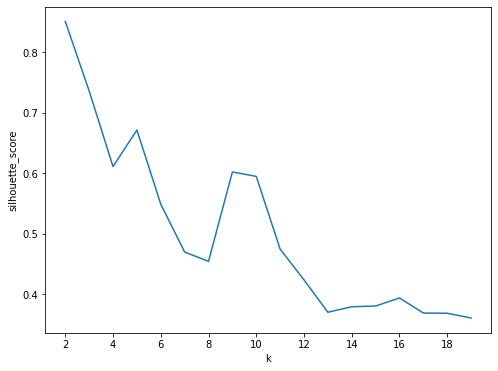

In [6]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(2)\
            .setFeaturesCol("features")\
            .setPredictionCol("prediction")

    model = kmeans.fit(transformed)
    
    print("Cluster Centers ", k)
    centers = model.clusterCenters()
    for center in centers:
        print(center)
    print()
    
    # Make predictions
    predictions = model.transform(transformed)
    predictions.show()

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()\
                .setFeaturesCol("features")\
                .setPredictionCol("prediction")\
                .setMetricName("silhouette")
    silhouette_score[k] = evaluator.evaluate(predictions)
    
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


In [7]:
kmeans = KMeans()\
        .setK(3)\
        .setSeed(1)\
        .setFeaturesCol("features")\
        .setPredictionCol("prediction")

model = kmeans.fit(transformed)
predictions = model.transform(transformed)
predictions.show(160)

+-----------------+----------+----------+
|         features|   variety|prediction|
+-----------------+----------+----------+
|[5.1,3.5,1.4,0.2]|    Setosa|         1|
|[4.9,3.0,1.4,0.2]|    Setosa|         1|
|[4.7,3.2,1.3,0.2]|    Setosa|         1|
|[4.6,3.1,1.5,0.2]|    Setosa|         1|
|[5.0,3.6,1.4,0.2]|    Setosa|         1|
|[5.4,3.9,1.7,0.4]|    Setosa|         1|
|[4.6,3.4,1.4,0.3]|    Setosa|         1|
|[5.0,3.4,1.5,0.2]|    Setosa|         1|
|[4.4,2.9,1.4,0.2]|    Setosa|         1|
|[4.9,3.1,1.5,0.1]|    Setosa|         1|
|[5.4,3.7,1.5,0.2]|    Setosa|         1|
|[4.8,3.4,1.6,0.2]|    Setosa|         1|
|[4.8,3.0,1.4,0.1]|    Setosa|         1|
|[4.3,3.0,1.1,0.1]|    Setosa|         1|
|[5.8,4.0,1.2,0.2]|    Setosa|         1|
|[5.7,4.4,1.5,0.4]|    Setosa|         1|
|[5.4,3.9,1.3,0.4]|    Setosa|         1|
|[5.1,3.5,1.4,0.3]|    Setosa|         1|
|[5.7,3.8,1.7,0.3]|    Setosa|         1|
|[5.1,3.8,1.5,0.3]|    Setosa|         1|
|[5.4,3.4,1.7,0.2]|    Setosa|    

In [8]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(transformed)

# rescale each feature to range [min, max].
scaledData = scalerModel.transform(transformed).cache()

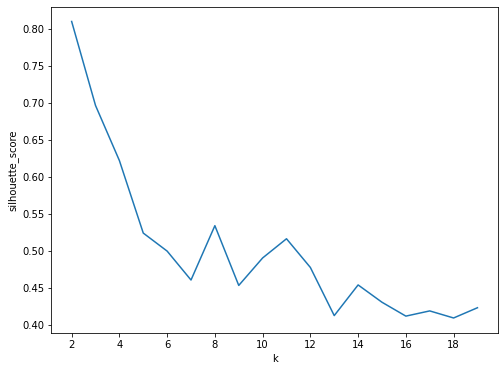

In [10]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(2)\
            .setFeaturesCol("scaledFeatures")\
            .setPredictionCol("prediction")

    model = kmeans.fit(scaledData)
    
    # Make predictions
    predictions = model.transform(scaledData)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()\
                .setFeaturesCol("scaledFeatures")\
                .setPredictionCol("prediction")\
                .setMetricName("silhouette")
    silhouette_score[k] = evaluator.evaluate(predictions)
    
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

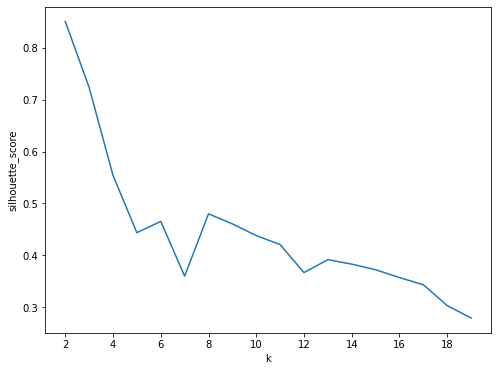

In [15]:
import numpy as np
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = np.zeros(20)
for k in range(2,20):
    kmeans = BisectingKMeans()\
            .setK(k)\
            .setSeed(2)\
            .setFeaturesCol("features")\
            .setPredictionCol("prediction")

    model = kmeans.fit(scaledData)
    
    # Return the K-means cost (sum of squared distances of points to their nearest center)
    # for this model on the given data.
    silhouette_score[k] = model.computeCost(scaledData) 
    
    # Make predictions
    predictions = model.transform(scaledData)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()\
                .setFeaturesCol("features")\
                .setPredictionCol("prediction")\
                .setMetricName("silhouette")
    silhouette_score[k] = evaluator.evaluate(predictions)
    
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

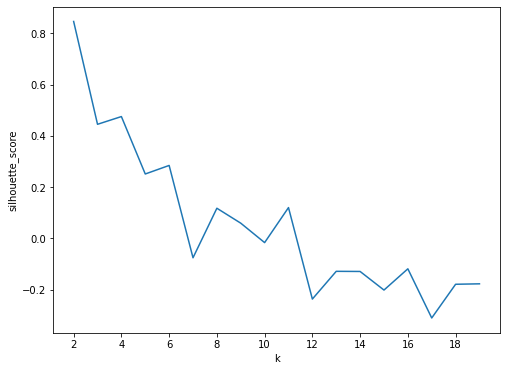

In [14]:
import numpy as np
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = np.zeros(20)
for k in range(2,20):
    alg = GaussianMixture()\
            .setK(k)\
            .setSeed(2)\
            .setFeaturesCol("scaledFeatures")\
            .setPredictionCol("prediction")

    model = alg.fit(scaledData)
    
    # Make predictions
    predictions = model.transform(scaledData)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()\
                .setFeaturesCol("features")\
                .setPredictionCol("prediction")\
                .setMetricName("silhouette")
    silhouette_score[k] = evaluator.evaluate(predictions)
    
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),silhouette_score[2:20])
ax.set_xlabel('k')
ax.set_ylabel('silhouette_score')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [17]:
# compare using kmeans.distanceMeasure() with 'euclidean' and 'cosine'
# see https://spark.apache.org/docs/latest/ml-clustering.html for other possible clustering algorithms
# see https://drive.google.com/file/d/0B0Hyo%5f%5fbG%5f3fdkNvSVNYX2E3ZU0/view for discussion about spark implementation of Silhouette

# exercise: read https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/
# (one hot encoder explanation: https://towardsdatascience.com/apache-spark-mllib-tutorial-7aba8a1dce6e)
# exercise: read https://george-jen.gitbook.io/data-science-and-apache-spark/train-validation-split
# exercise: compare to https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation
# exercise: convert sample notebook into pipeline using ParamGridBuilder and TrainValidationSplit
# exercise: prepare a docker image that would automatize this exercise